In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pymc3 as pm
import theano.tensor as tt
import weibull
from scipy.stats import exponweib
import time


import os
import shutil
import ctypes
import time


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\xjl19\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\xjl19\Anaconda3\lib\site-packages\weibull\__init__.py:9: UserWarning: The "weibull" module is being superceded by the "reliability" module and will no longer be maintained. Please refactor your code for this alternative model and thank you for using 

In [39]:
data = exponweib.rvs(a=1, c=0.7, loc=0, scale=30, size=20)
#  型号2——1
# data = [776.09, 114.93, 145.95, 1058.38, 513.90, 482.00,
#         363.90, 336.04, 337.64, 251.38, 457.58, 596.92,
#          1.75, 104.37, 143.31, 554.34, 639.31, 346.31,
#          219.80, 448.78, 793.57, 332.55, 1007.25, 134.15,
#          85.90, 389.28, 65.43, 249.78, 59.39, 592.12,
#          964.43, 752.49, 475.92, 212.65, 759.03, 289.36,
#          127.02, 41.73, 52.07, 94.24, 272.90, 741.86,
#          657.01, 18.64, 113.62, 105.28, 359.97, 218.97,
#          335.24, 250.72, 45.16, 314.41, 196.28, 16.10,
#          13.99, 242.81, 102.14, 99.69, 60.81, 870.35,
#          524.40, 157.39, 20.90]

# 型号1-1
# data = [776.09, 143.31, 513.90, 157.39, 1007.25, 346.31, 272.90, 475.92, 9.36]

# # 型号2-2
# data = [176.0, 248.00, 10.50, 472.00, 45.00, 39.00, 209.33, 261.25, 510.00, 120.00, 224.00, 348.00, 267.50, 32.00, 50.00, 138.50, 398.00, 353.00, 478.00, 137.06,]

# data = np.array(data)
# data = np.random.exponential(357,10)
data[:10]

array([ 62.68556388,  29.08121036,   1.14988057,  39.77753016,
         6.22721891,  56.43663944,  14.34319967,   5.89392677,
       111.15861708,  38.79326972])

In [17]:
class Translate(pm.distributions.transforms.Transform):
  def __init__(self, v):
    self.v_ = v

  def forward(self, x):
    return x + self.v_

  def forward_val(self, x):
    return x + self.v_

  def backward(self, z):
    return x - self.v_

  def jacobian_det(self, x):
    return 0. * x  # log(1) = 0

  def apply(self, rv):
    return pm.distributions.transforms.TransformedDistribution.dist(rv.distribution, self)

In [11]:
class Nuts_weib():
    def __init__(self,data):
        self.data = data
        
    def classic_estimate(self):
        self.analysis = weibull.Analysis(self.data)
        self.analysis.fit('mle')
#         self.analysis.fit()
 
    def model_flat(self,a,b):
        with pm.Model() as model_gibbs:
            a = pm.HalfFlat('a',testval=a)
            b = pm.HalfFlat('b',testval=b)
            like = pm.Weibull('observation', a, b, observed=self.data)
            prior = pm.Potential('prior', -tt.log(a*b))
            
            # inference
            start = pm.find_MAP()
            self.trace = pm.sample(1250,tune=1000,start=start)
    
    def model_gamma(self,a,b,num1,num2):            
        with pm.Model() as model_1:
#             l = pm.Gamma('l_pr', alpha=2,beta=1)
            a = pm.Gamma('a',alpha=3 , beta=3,testval=a)            
            b = pm.Gamma('b', alpha=90 , beta=3,testval=b)   
#             shift = Translate(l)
#             weib = shift.apply(pm.Weibull('base', alpha=a, beta=b,observed=self.data))
            weib = pm.Weibull('base', alpha=a, beta=b,observed=self.data)   
#             start = pm.find_MAP()
            self.trace = pm.sample(1250,tune=1000)
        
            

# nuts_weib = Nuts_weib(data)

# # # # nuts_weib.classic_estimate()
# # # # nuts_weib.analysis.fit('mle')
# # # # nuts_weib.analysis.stats


# nuts_weib.model_gamma()
# # a = nuts_weib.trace_gamma

In [5]:
from time import time

# alpha = 0.7
alpha = 2
beta = 30
size = 200

start_time = time()

enum_gamma=0
enum_flat=0

li = np.load('s200/gamma_200.npy').tolist()

j_li = []
means_li = []
i = 0
j = 1030
while True:
    end_time = time()
    print('总时长%ds'%(end_time-start_time))
    print('flat错误，%d次'%enum_flat)

    print('第' + str(i+1)+'次')
    try:
        np.random.seed(seed=2500 + li[i])
    except:
        print('使用备用数据%d'%j)
        np.random.seed(seed=2500 + j)
        j += 1
    data = exponweib.rvs(a=1, c=alpha, loc=0, scale=beta, size=size)
    nuts_weib = Nuts_weib(data)
    try:
        nuts_weib.model_flat()
    except:
        i += 1
        enum_gamma += 1
        continue
    print('saving...')
    li.append(i)
    np.save('s_flat_' + str(size) + '/flat_' +str(size)  + '.npy',li)
    pm.trace_to_dataframe(nuts_weib.trace_flat).to_csv('s_flat_' + str(size) + '/flat_' +str(size) + '_' + str(i) + '.csv')
    
    i+= 1
    if len(li) == 1000:
        break

In [ ]:
def do(alpha,beta,size,model):
    
    start_time = time.time()
    enum=0
    li = np.load('seed.npy').tolist()
    for i,seed in enumerate(li):
        print(f'第{str(i+1)}次--------------------------------------------------')
        print(f'随机核：{str(li[i])}')
        
        np.random.seed(seed=2500 + li[i])
        data = exponweib.rvs(a=1, c=alpha, loc=0, scale=beta, size=size)
        nuts_weib = Nuts_weib(data)
        
        try:
            if model == 1:
                nuts_weib.model_flat(alpha,beta)
                string = 'flat'
            elif model == 2:
                if alpha == 0.7:
                    num1 = 3
                elif alpha == 1:
                    num1 = 4
                elif alpha == 2:
                    num1 = 7
                    
                if beta == 30:
                    num1 = 90
                elif beta == 200:
                    num1 = 600
                nuts_weib.model_gamma(alpha,beta,num1,num2)
                string = 'gamma'
        except:
            enum += 1
            print('错误')
            continue
        
        try:
            pm.trace_to_dataframe(nuts_weib.trace).to_csv(str(alpha)+ '_' + str(beta)+ '_s_' + string + '_' + str(size) + '/' +string + '_' +str(size) + '_' + str(i) + '.csv')
        except:
            os.mkdir(str(alpha)+ '_' + str(beta)+ '_s_' + string + '_' + str(size))
            pm.trace_to_dataframe(nuts_weib.trace).to_csv(str(alpha)+ '_' + str(beta)+ '_s_' + string + '_' + str(size) + '/' +string + '_' +str(size) + '_' + str(i) + '.csv')
        
        end_time = time.time()
        print(f'总时长{end_time - start_time}s')
        print(f'错误次数：{str(enum)}')
       
do(0.7,30,20,1)
do(0.7,30,20,2)
do(0.7,30,50,1)
do(0.7,30,50,2)
do(0.7,30,100,1)
do(0.7,30,100,2)
# do(0.7,30,200,1)
# do(0.7,30,200,2)
do(0.7,30,500,1)
do(0.7,30,500,2)
do(0.7,30,1000,1)
do(0.7,30,1000,2)

do(0.7,600,20,1)
do(0.7,600,20,2)
do(0.7,600,50,1)
do(0.7,600,50,2)
do(0.7,600,100,1)
do(0.7,600,100,2)
do(0.7,600,200,1)
do(0.7,600,200,2)
do(0.7,600,500,1)
do(0.7,600,500,2)
do(0.7,600,1000,1)
do(0.7,600,1000,2)

do(1,30,20,1)
do(1,30,20,2)
do(1,30,50,1)
do(1,30,50,2)
do(1,30,100,1)
do(1,30,100,2)
do(1,30,200,1)
do(1,30,200,2)
do(1,30,500,1)
do(1,30,500,2)
do(1,30,1000,1)
do(1,30,1000,2)

do(1,600,20,1)
do(1,600,20,2)
do(1,600,50,1)
do(1,600,50,2)
do(1,600,100,1)
do(1,600,100,2)
do(1,600,200,1)
do(1,600,200,2)
do(1,600,500,1)
do(1,600,500,2)
do(1,600,1000,1)
do(1,600,1000,2)

do(2,30,20,1)
do(2,30,20,2)
do(2,30,50,1)
do(2,30,50,2)
do(2,30,100,1)
do(2,30,100,2)
do(2,30,200,1)
do(2,30,200,2)
do(2,30,500,1)
do(2,30,500,2)
do(2,30,1000,1)
do(2,30,1000,2)

do(2,600,20,1)
do(2,600,20,2)
do(2,600,50,1)
do(2,600,50,2)
do(2,600,100,1)
do(2,600,100,2)
do(2,600,200,1)
do(2,600,200,2)
do(2,600,500,1)
do(2,600,500,2)
do(2,600,1000,1)
do(2,600,1000,2)       

第1次--------------------------------------------------
随机核：0


C:\Users\xjl19\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -96.954, ||grad|| = 4.8427: 100%|██████████████████████████████████████████████| 10/10 [00:00<00:00, 213.54it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]


In [17]:
np.random.seed(seed=2501)
data = exponweib.rvs(a=1, c=2, loc=0, scale=30, size=20)
nuts_weib = Nuts_weib(data)
nuts_weib.model_flat()

C:\Users\xjl19\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -84.268, ||grad|| = 8.3281: 100%|██████████████████████████████████████████████| 10/10 [00:00<00:00, 213.42it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 9000/9000 [00:33<00:00, 265.56draws/s]
C:\Users\xjl19\Anaconda3\lib\site-packages\mkl_fft\_nump

In [7]:
from time import time
from tqdm import tqdm

alpha = 0.7
beta = 30
size = 200

start_time = time()

enum_gamma=0
enum_flat=0

li = np.load('s200/gamma_200.npy').tolist()
estimates=[]
j_li = []
means_li = []
i = 0
j = 1030
for i in tqdm(li):
    end_time = time()
    np.random.seed(seed=2500 + i)

    data = exponweib.rvs(a=1, c=alpha, loc=0, scale=beta, size=size)
    analysis = weibull.Analysis(data)
    analysis.fit('mle')
    estimates.append([analysis.stats[3],analysis.stats[6]])
    
print('saving...')
df = pd.DataFrame(estimates,columns = ['a','b'])
print(df)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:24<00:00,  4.85it/s]


saving...
            a          b
0    0.653745  28.249664
1    0.723958  32.317833
2    0.617179  26.801470
3    0.603130  24.050801
4    0.686223  31.386664
5    0.701773  34.247883
6    0.774921  33.768590
7    0.662945  27.317654
8    0.687348  30.131455
9    0.719143  29.862910
10   0.667411  29.803011
11   0.703860  24.992487
12   0.757847  33.510903
13   0.717535  31.083059
14   0.678413  30.595910
15   0.692305  26.646236
16   0.702394  28.995629
17   0.674509  22.489624
18   0.644077  27.633886
19   0.712654  28.137433
20   0.652330  26.447915
21   0.671994  31.802855
22   0.692537  28.063982
23   0.702212  29.858590
24   0.685744  30.923893
25   0.687260  22.512876
26   0.686364  26.814668
27   0.657058  36.116331
28   0.703980  33.909853
29   0.693376  25.742144
..        ...        ...
970  0.721038  34.449371
971  0.713729  29.321221
972  0.713740  29.156712
973  0.683122  29.131888
974  0.634635  34.299642
975  0.767885  27.810970
976  0.815374  29.729721
977  0.743716  

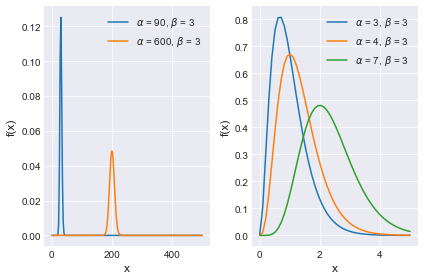

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
plt.subplot(1,2,1)
x = np.linspace(0, 500, 200)
alphas = [90,600]
betas = [3,3]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.subplot(1,2,2)
x = np.linspace(0, 5, 50)
alphas = [3,4,7]
betas = [3,3,3]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [13]:
time.time()

1583044366.1483474